<a href="https://colab.research.google.com/github/VPonomarev42/LearningRep/blob/stats_miniproject_5/stats/stats_miniproject_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import iqr
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import levene
from scipy.stats import f_oneway
%matplotlib inline

На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

* В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
* Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый 

Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения

# **Задания**:
1. Выберите метод, который предположительно подойдет в первом вопросе.
2. Проверьте, являются ли дисперсии внутри групп гомогенными.
3. Проведите тест на нормальность распределения.
4. Сравните средние в представленных группах.
5. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 
6. Примите решение: какие картинки в итоге будем использовать?
7. Выберите метод для второго теста.
8. Визуализируйте распределение events для контрольной и тестовой групп. 
9. Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя. 
10. Выберите формулу для модели, проведите тест.


# **Описание данных**
**[5_task_1](https://stepik.org/media/attachments/lesson/385920/5_task_1.csv "5_task_1"):**

**id** – id клиента в эксперименте  
**group** – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)  
**events** – сколько блюд суммарно было заказано за период

**[5_task_2](https://stepik.org/media/attachments/lesson/385920/5_task_2.csv "5_task_2"):**  
**id** – id клиента в эксперименте  
**segment** – сегмент (high/low)  
**group** – вид кнопки (control – старая версия, test – новая версия)  
**events** – сколько блюд суммарно было заказано за период

1. Выберите метод, который предположительно подойдет в первом вопросе.

Уточнение условия задачи: пользователю показываются 2 вида прямоугольных и квадратные изображения. Имеем 3 группы для сравнения. Для исследования будем использовать дисперсионный анализ, метод ANOVA. 

2.Проверьте, являются ли дисперсии внутри групп гомогенными.

In [2]:
task1 = pd.read_csv('https://stepik.org/media/attachments/lesson/385920/5_task_1.csv')
task1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [3]:
task1.shape

(30000, 3)

In [4]:
task1.isna().value_counts()

id     group  events
False  False  False     30000
dtype: int64

In [12]:
group_a = task1[task1.group == 'A']

In [10]:
group_b = task1[task1.group == 'B']

In [20]:
group_c = task1[task1.group == 'C']

In [18]:
np.var(group_a.events, ddof=1)

101.59382322232213

In [19]:
np.var(group_b.events, ddof=1)

96.99019405940611

In [23]:
np.var(group_c.events, ddof=1)

99.1826361736163

In [22]:
levene(group_a.events, group_b.events, group_c.events)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

Тест на гомогенность дисперсии Левена показал p-value > 0.05, это позволяет нам сделать вывод о том, что нулевую гипотезу о гомогенности(приблизительном равенстве) дисперсии в трех группах мы отклонить не можем.

3.Проведите тест на нормальность распределения.

Для этого возьмём случайные выборки по 1000 элементов из каждой группы и проведём проверку с помощью метода Шапиро-Уилка.

In [31]:
gr_a_sample = group_a['events'].sample(1000,random_state=17)
gr_b_sample = group_b['events'].sample(1000,random_state=17)
gr_c_sample = group_c['events'].sample(1000,random_state=17)

In [32]:
shapiro(gr_a_sample)

(0.9973153471946716, 0.09609563648700714)

In [33]:
shapiro(gr_b_sample)

(0.9980798363685608, 0.31768906116485596)

In [34]:
shapiro(gr_c_sample)

(0.9981185793876648, 0.3359004259109497)

Тест Шапиро-Уилка показал для всех групп p-value > 0.05, что не дает нам отклонить нулевые гипотезу о нормальном распределение этих групп.

4.Сравните средние в представленных группах.

Для сравнения среднего в этих группах будем использовать однофакторный метод дисперсионного анализа F_oneway

In [37]:
f_oneway(group_a.events, group_b.events, group_c.events)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

Результат тестирования показал p-value близкое к 0, что не позволяет отбросить нулевую гипотезу о равенстве средних в этих группах 

5. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия.

In [38]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [41]:
tukey_result = pairwise_tukeyhsd(task1.events, task1.group)

In [44]:
tukey_result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


Text(0.5, 1.0, 'Сравнение групп')

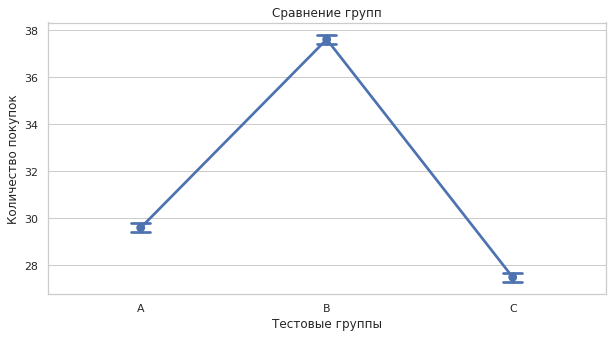

In [48]:
sns.set(rc={'figure.figsize':(10,5)}, style='whitegrid')
sns.pointplot(data=task1, x='group', y='events', capsize=0.1)
plt.xlabel('Тестовые группы')
plt.ylabel('Количество покупок')
plt.title('Сравнение групп')

Тест Тьюки показывает, что при попарном взаимодествии мы отвергаем нулевую гипотезу о равенстве средних между всеми тремя группами.  
График также показывает явные различия в количестве покупок между группами

6.Примите решение: какие картинки в итоге будем использовать?

Картинки, которые использовались в группе B оказали наибольшее влияние на среднее количество покупок в приложении. Следовательно, лучше использовать именно их.

7.Выберите метод для второго теста.

Уточнение к условию: помимо контрольной и тестовой групп необходимо учитывать сегмент пользователя: высокий или низкий.
Получается, что в эксперименте присутствует зависимая переменная - количество покупок и две независимые - сегмент и группа.
Для анализа будем использовать многофакторный дисперсионный анализ

8.Визуализируйте распределение events для контрольной и тестовой групп.